# Classification notebook
### No feature extraction here - will load from pickle file

In [1]:
import pickle
import numpy as np
import pandas as pd
import json
import random
from tqdm import tqdm
import matplotlib.pyplot as plt
plt.style.use('seaborn')

from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
import xgboost
from sklearn import svm
from sklearn.naive_bayes import GaussianNB
from sklearn.dummy import DummyClassifier

from sklearn.metrics import accuracy_score, f1_score, roc_curve

In [2]:
def rand_emot():
    e = ["(o_o)",":-)",":P",":D","x)","ᓚᘏᗢ","╯°□°）╯︵ ┻━┻",":)",
         "*<:-)","^_^","(⌐■_■)","¯\_(ツ)_/¯", "(T_T)",":o","OwO",
        "( ͡❛ ͜ʖ ͡❛)","(̶◉͛‿◉̶)","( ≖.≖)","(ㆆ_ㆆ)","ʕ•́ᴥ•̀ʔっ","( ◡́.◡̀)","(^◡^ )"]
    return random.choice(e)

def load_files():
    text_pairs = [] #Would be nice to have as np.array
    labels = []
    fandom = []
    
    pair_id = []
    true_id = []
    
    #Load truth JSON
    for line in open('data/modified/train_truth.jsonl'):
        d = json.loads(line.strip())
        labels.append(int(d['same']))
        true_id.append(d['id'])

    #Load actual fanfic.
    print("loading fanfic...",rand_emot())
    for line in tqdm(open('data/modified/train_pair.jsonl')):
        d = json.loads(line.strip())
        text_pairs.append(d['pair'])
        fandom.append(d['fandoms'])
        pair_id.append(d['id'])

    print("done loading",rand_emot())
    
    return text_pairs, labels, fandom, pair_id, true_id

In [5]:
_, labels, _, _, _ = load_files()    #11550
labels.pop(713)

egg

284it [00:00, 2818.39it/s]

loading fanfic... ╯°□°）╯︵ ┻━┻


1578it [00:00, 2692.29it/s]

done loading (ㆆ_ㆆ)


1

In [6]:
def save_features(feature_dict, filename='features'):
    '''Save the updated feature dictionary. Takes dictionary as input and saves as binary file
    
    example: 
    >>> my_featues = {'freqdist': [1,6,3,5]}
    >>> save_features(my_features)'''
    
    with open('data/{}.dat'.format(filename), 'wb') as file:
        pickle.dump(feature_dict, file)
    print("Features saved! :-)")

def load_features(filename='features'):
    '''Load feature dictionary. Returns the saved feature as a dictionary.
    
    example: 
    >>> my_features = load_features()'''
    
    with open('data/{}.dat'.format(filename), 'rb') as file:
        feats = pickle.load(file)
    print("Features available:")
    for i in feats.keys():
        print(i)
    return feats

In [7]:
feats = load_features(filename="features_0706")

Features available:
character_bigram
skip_bigram
pos_skipgram
pos_bigram
character_bigram_cossim
skip_bigram_cossim
pos_skipgram_cossim
pos_bigram_cossim
function_word_dist
profanity_dist
unique_words
punctuation_proportion
avg_word_length
avg_sent_length
yules
lix


In [8]:
for i in feats:
    if len(feats[i].shape)==1:
        feats[i] = feats[i][:,None]
    print(i, "\t", feats[i].shape)


character_bigram 	 (1577, 6000)
skip_bigram 	 (1577, 8000)
pos_skipgram 	 (1577, 2208)
pos_bigram 	 (1577, 6000)
character_bigram_cossim 	 (1577, 1)
skip_bigram_cossim 	 (1577, 1)
pos_skipgram_cossim 	 (1577, 1)
pos_bigram_cossim 	 (1577, 1)
function_word_dist 	 (1577, 1)
profanity_dist 	 (1577, 1)
unique_words 	 (1577, 1)
punctuation_proportion 	 (1577, 1)
avg_word_length 	 (1577, 1)
avg_sent_length 	 (1577, 1)
yules 	 (1577, 1)
lix 	 (1577, 1)


## Stratified K-Fold

In [20]:
def strat_kfold(model, X, k):
    y = np.array(labels)
    targets = []
    preds = []
    preds_proba = []
    skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=69)
    for train_index, test_index in skf.split(X, y):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        model.fit(X_train, y_train)
        preds.append(model.predict(X_test))
        preds_proba.append(model.predict_proba(X_test))
        targets.append(y_test)
    
    return np.array([item for elem in preds for item in elem]), np.array([item for elem in targets for item in elem]), np.array([item for elem in preds_proba for item in elem])

def combine_features(features):
    #List of features as input
    return np.hstack((features))

In [14]:
#Stratified 2-Fold accuracy on ALL Features
all_features = combine_features([feats[x] for x in feats])
scalar_features = combine_features([feats[x] for x in feats if feats[x].shape[1]==1])
forced_scalars = []
for i in feats:
    if feats[i].shape[1] >1:
        forced_scalars.append(np.mean(feats[i], axis=1)[:,None])
    else:
        forced_scalars.append(feats[i])

forced_scalars = combine_features(forced_scalars)
vector_features = combine_features([feats['character_bigram'],
                                  feats['skip_bigram'],
                                  feats['pos_skipgram']])

final_features = combine_features([feats['function_word_dist'],
                                 feats['profanity_dist'],
                                 feats['avg_sent_length'],
                                 feats['avg_word_length'],
                                 feats['lix'],
                                 feats['yules'],
                                 feats['unique_words'],
                                 feats['punctuation_proportion'],
                                 feats['character_bigram_cossim'],
                                 feats['skip_bigram_cossim'],
                                 feats['pos_skipgram_cossim'],
                                 feats['pos_bigram_cossim']])

print("All features:",all_features.shape)
print("Scalar features:", scalar_features.shape)
print("Forced scalar features:", forced_scalars.shape)
print("Vector features:", vector_features.shape)
print("Final features:", final_features.shape)

All features: (1577, 22220)
Scalar features: (1577, 12)
Forced scalar features: (1577, 16)
Vector features: (1577, 16208)
Final features: (1577, 12)


In [15]:
def try_different_feats(model):
    all_preds, all_targs, all_pred_proba = strat_kfold(model, all_features, 5)
    vec_preds, vec_targs, vec_pred_proba = strat_kfold(model, vector_features, 5)
    fin_preds, fin_targs, fin_pred_proba = strat_kfold(model, final_features, 5)
    
    print("All features: F1={}\tAcc={}".format(f1_score(all_targs, all_preds), accuracy_score(all_targs, all_preds)))
    print("Vector features: F1={}\tAcc={}".format(f1_score(vec_targs, vec_preds), accuracy_score(vec_targs, vec_preds)))
    print("Final features: F1={}\tAcc={}".format(f1_score(fin_targs, fin_preds), accuracy_score(fin_targs, fin_preds)))
    
    return [(all_pred_proba, all_targs), (vec_pred_proba, vec_targs), (fin_pred_proba, fin_targs)]

## Random Forest

In [21]:
rfc = RandomForestClassifier(n_estimators=500, random_state=42, n_jobs=4)
rfc_results = try_different_feats(rfc)

All features: F1=0.7689008042895442	Acc=0.7266962587190868
Vector features: F1=0.7033609352167559	Acc=0.6138237159162968
Final features: F1=0.7936313533374159	Acc=0.7863031071655041


In [22]:
#Stratified 5-Fold on the 8k best Random Forest Features
#rfc_8k_feats = all_features[:,rfc.feature_importances_.argsort()[-8000:][::-1]]
#strat_kfold(rfc, rfc_8k_feats, 5)

In [23]:
X_train, X_test, y_train, y_test = train_test_split(final_features, labels)

dist = {
    'n_estimators' : [100,200,300,500,1000],
    'min_samples_split': [2,4,6,8],
    'min_samples_leaf': [1,2,3,4,5],
}
random_search = RandomizedSearchCV(rfc, dist, n_iter=20, random_state=42)
search = random_search.fit(X_train, y_train)
params = search.best_params_
search.score(X_test, y_test)

0.7746835443037975

In [24]:
strat_kfold(search, final_features, 5)

(array([0, 1, 1, ..., 1, 0, 0]),
 array([0, 0, 1, ..., 1, 0, 0]),
 array([[0.930818  , 0.069182  ],
        [0.23518193, 0.76481807],
        [0.03472341, 0.96527659],
        ...,
        [0.08727778, 0.91272222],
        [0.7880754 , 0.2119246 ],
        [0.79817857, 0.20182143]]))

## XGBoost

In [25]:
xgb = xgboost.XGBClassifier(random_state=42)
xgb_results = try_different_feats(xgb)

c:\python37\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:20:55] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:21:42] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:22:29] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:23:16] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

c:\python37\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:24:50] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:25:32] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:26:14] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:26:57] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

c:\python37\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:28:21] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:28:21] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:28:22] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:28:22] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

In [26]:
X_train, X_test, y_train, y_test = train_test_split(final_features, labels, random_state=42)

dist = {
    'n_estimators' : [100,200,300,500,1000,2000],
    'max_depth' : [6,7,8,9,10],
    'gamma' : [0,1,2,3,5,8],
    'learning_rate':[0.003, 0.01, 0.03, 0.1],
    "eval_metric": ["logloss", "error"],
}
random_search = RandomizedSearchCV(xgb, dist, n_iter=20, random_state=42)
search = random_search.fit(X_train, y_train)
params = search.best_params_
search.score(X_test, y_test)

c:\python37\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


0.7670886075949367

## Support Vector Machine

In [28]:
svm_clf = svm.SVC(probability=True, random_state=42)
svc_results = try_different_feats(svm_clf)

All features: F1=0.735195530726257	Acc=0.699429296131896
Vector features: F1=0.6967340590979783	Acc=0.6290424857324033
Final features: F1=0.7282913165266107	Acc=0.6924540266328472


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(final_features, labels)

dist = {
    'C' : [1,2,3],
    'gamma' : ['scale', 'auto'],
}
random_search = RandomizedSearchCV(svm_clf, dist, n_iter=20, random_state=42)
search = random_search.fit(X_train, y_train)
params = search.best_params_
search.score(X_test, y_test)

## Logistic Regression

In [29]:
lrg = LogisticRegression(max_iter=2000, n_jobs=4, random_state=42
lrg_results = try_different_feats(lrg)

All features: F1=0.8186588921282798	Acc=0.8027901077996196
Vector features: F1=0.6608122941822173	Acc=0.6081166772352569
Final features: F1=0.7853403141361256	Acc=0.7660114140773621


## Naive Bayes

In [30]:
nb = GaussianNB(random_state=42)
nb_results = try_different_feats(nb)

All features: F1=0.6350404312668463	Acc=0.570703868103995
Vector features: F1=0.603943661971831	Acc=0.5542168674698795
Final features: F1=0.7845117845117845	Acc=0.7564996829422955


## MLP Test

In [31]:
mlp = MLPClassifier(max_iter=1000, random_state=42)
mlp_results = try_different_feats(mlp)

All features: F1=0.7463893703061815	Acc=0.7216233354470514
Vector features: F1=0.6378132118451025	Acc=0.5967025998731769
Final features: F1=0.7943760984182776	Acc=0.777425491439442


## Dummy Baseline

In [32]:
dummy = DummyClassifier(random_state=42)
dummy_results = try_different_feats(dummy)

c:\python37\lib\site-packages\sklearn\dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)
c:\python37\lib\site-packages\sklearn\dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)


All features: F1=0.5251798561151079	Acc=0.49778059606848446
Vector features: F1=0.5201201201201202	Acc=0.4933417882054534
Final features: F1=0.540508574807806	Acc=0.507292327203551


c:\python37\lib\site-packages\sklearn\dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)


## ROC Curve

In [33]:
def plot_roc_cur(fper, tper, label="", title="plot title"):
    plt.plot(fper, tper, label=label)
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc='lower right')
    
def create_roc_curve(preds, targets, label="", title=""):
    all_fpr, all_tpr = [], []
    print(preds[:,1])
    fpr, tpr, thresholds = roc_curve(targets, preds[:,1]) #De her burde vist være nyttet om...
    all_fpr.append(fpr)
    all_tpr.append(tpr)
    all_fpr = np.array(all_fpr)
    all_tpr = np.array(tpr)
    
    plot_roc_cur(all_fpr[0], all_tpr, label=label, title=title)

In [36]:
labels = ['Random Forest', 'Support Vector Machine', 'Logistic Regression', 'XGBoost', 'Multilayer Perceptron']
all_results = [rfc_results[0][0], svc_results[0][0], lrg_results[0][0], xgb_results[0][0], mlp_results[0][0]]
all_targets = [rfc_results[0][1], svc_results[0][1], lrg_results[0][1], xgb_results[0][1], mlp_results[0][1]]

vec_results = [rfc_results[1][0], svc_results[1][0], lrg_results[1][0], xgb_results[1][0], mlp_results[1][0]]
vec_targets = [rfc_results[1][1], svc_results[1][1], lrg_results[1][1], xgb_results[1][1], mlp_results[1][1]]

fin_results = [rfc_results[2][0], svc_results[2][0], lrg_results[2][0], xgb_results[2][0], mlp_results[2][0]]
fin_targets = [rfc_results[2][1], svc_results[2][1], lrg_results[2][1], xgb_results[2][1], mlp_results[2][1]]

[0.484 0.57  0.642 ... 0.614 0.46  0.376]
[0.57607557 0.81662646 0.79348595 ... 0.75152654 0.28831576 0.10726647]
[0.20752006 0.83315123 0.88507879 ... 0.76088865 0.30180406 0.02739544]
[0.15369123 0.97744036 0.99407506 ... 0.9946024  0.01062109 0.03460389]
[5.53112238e-01 9.66671343e-01 4.35838215e-01 ... 8.76268268e-01
 2.57079082e-02 2.29639606e-04]


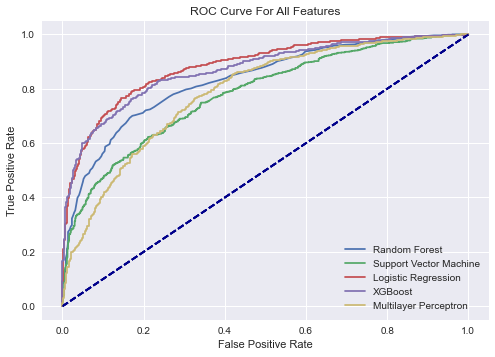

In [37]:
for i in range(len(all_results)):
    create_roc_curve(all_results[i], all_targets[i], label=labels[i], title="ROC Curve For All Features")

[0.572 0.58  0.56  ... 0.584 0.54  0.458]
[0.53973468 0.74986234 0.61933457 ... 0.76306733 0.64609593 0.25126132]
[0.61316032 0.67886226 0.53645808 ... 0.69849237 0.55103583 0.39483343]
[0.95704776 0.91462433 0.29496625 ... 0.99780256 0.3692926  0.8521154 ]
[0.96427863 0.9561621  0.03414349 ... 0.92101424 0.01050732 0.0158442 ]


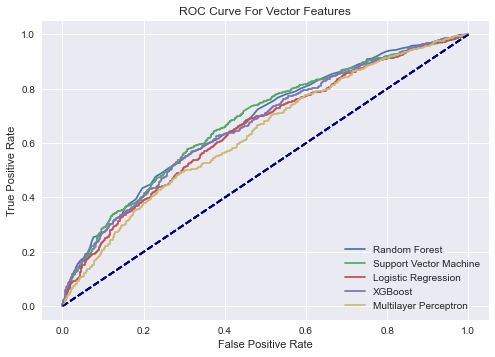

In [38]:
for i in range(len(vec_results)):
    create_roc_curve(vec_results[i], vec_targets[i], label=labels[i], title="ROC Curve For Vector Features")

[0.062 0.786 0.948 ... 0.968 0.176 0.23 ]
[0.46641317 0.79512707 0.79947822 ... 0.7520772  0.25175476 0.13634503]
[0.13019342 0.74140624 0.91778544 ... 0.76440874 0.33236516 0.04453122]
[0.00268489 0.7966953  0.99362224 ... 0.99880314 0.04506864 0.06483506]
[0.0571555  0.7672677  0.98238899 ... 0.86653864 0.21588969 0.04756168]


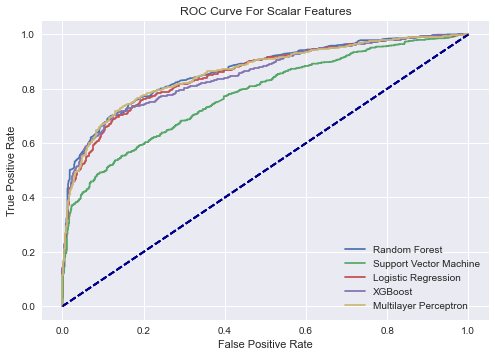

In [39]:
for i in range(len(fin_results)):
    create_roc_curve(fin_results[i], fin_targets[i], label=labels[i], title="ROC Curve For Scalar Features")